### Imports and Loading of Data
#### By Cliff Gong, Gen Ho, Xinqian Zhai

In [1]:
import numpy as np 
import pandas as pd 

import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from scipy.stats import pearsonr
from itertools import combinations

# this is the libary for conducting statistical significance tests on correlation coefficients.
# https://github.com/psinger/CorrelationStats
from corrstats import independent_corr

(-0.8912799047605414, 0.3749185174912557)
(1.0171097212822693, 0.3091012362386931)


In [2]:
df_merge = pd.read_csv('./output/merge.csv')

### Nominated State ROI Trend

First we take a look at the ROI trend for the nominated states California, New York and Texas to see if there are any obvious trends such as upward or downward movement. We see that there is no noticeable change in trends that seem to be related to covid. An upward trend starts around Jan 2019, continues to rise smoothly through the start of the pandemic and doesn't begin to go down until Jan 2021.

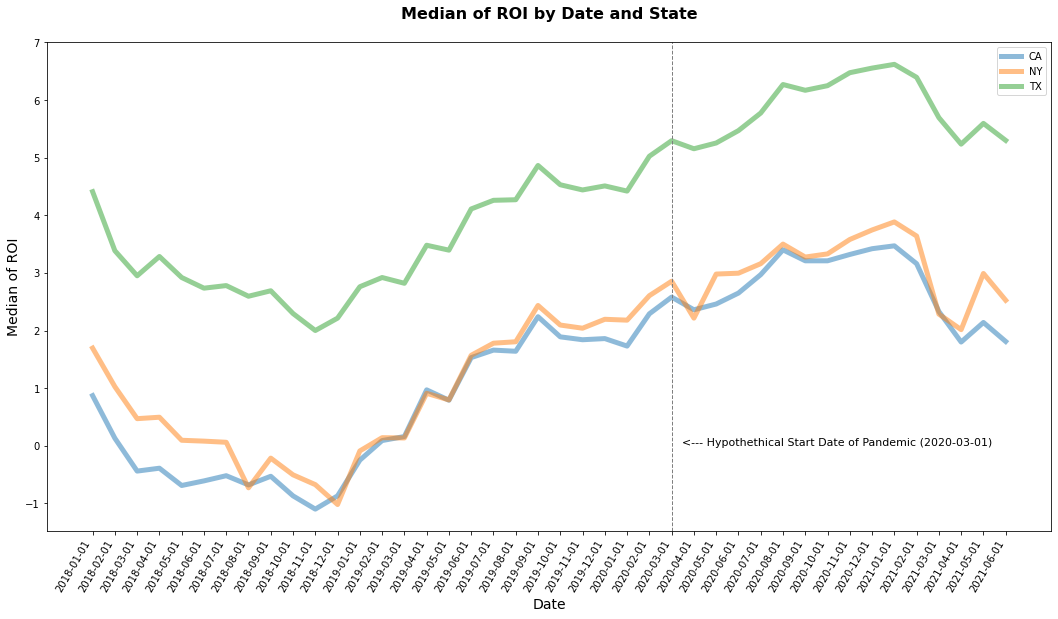

In [3]:
states = ['CA','NY','TX']

plt.figure(figsize=(18,9))
plt.title('Median of ROI by Date and State\n', fontdict={'fontsize':16, 'fontweight':600})
plt.xlabel('Date', fontdict={'fontsize':14})
plt.ylabel('Median of ROI', fontdict={'fontsize':14})

for state in states:
    df = df_merge[df_merge['state']==state].groupby('date').median()
    ax = plt.plot(df['roi'], label=state, linewidth=5, alpha=0.5)

pandemic_start_date = '2020-03-01'
plt.axvline(pandemic_start_date, linewidth=1, linestyle='--', color='C7')
message = '<--- Hypothethical Start Date of Pandemic ({})'.format(pandemic_start_date)
plt.annotate(message, (pandemic_start_date,0), (10,0), 
                xycoords='data', textcoords='offset points',
                fontsize=11, ha='left', color='black')

plt.xticks(rotation=60, ha='right')
plt.legend(loc="best")

plt.show()

### State level correlation study 

In [4]:
df_ca = df_merge[df_merge['state']=='CA']
df_tx = df_merge[df_merge['state']=='TX']
df_ny = df_merge[df_merge['state']=='NY']

Firstly, we take CA as an example. Focusing on ROI with other variables, noticed there are sub-groups patterns (by county). 

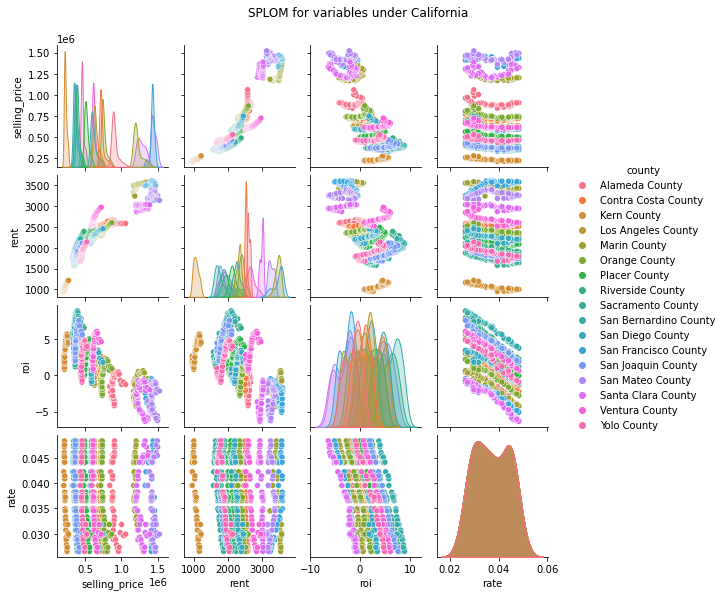

In [5]:
g = sns.pairplot(df_ca, hue='county', height=2)
g.fig.suptitle("SPLOM for variables under California", y=1.03, fontsize='12')
plt.show()

We then calculate the correlation coefficient for CA. Result shows the strength of correlation for ROI is: Selling Price &gt; Rent &gt; Rate

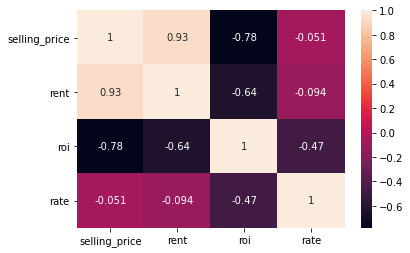

In [6]:
sns.heatmap(df_ca.corr(), annot=True)
plt.show()

Further filter the dataframe by Alameda County. Calculate the correlation coefficient again. For ROI, this time the strength of correlation is: ROI &gt; Rent &gt; Selling Price. Believe Between-group correlation rather than Total-correlation provides a better view on the relationship between variables. 

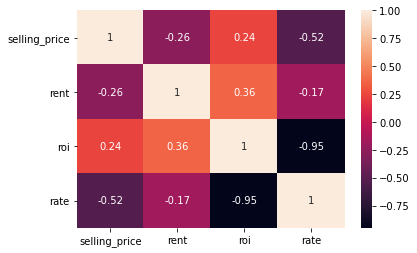

In [7]:
df_ca_alameda = df_ca[df_ca['county'] == 'Alameda County']
sns.heatmap(df_ca_alameda.corr(), annot=True)

Using Between-group (by county) correlation coefficient rather than total correlation (by state) 

In [8]:
def generate_corr_single_df(df_a):

    counties = df_a['county'].unique().tolist()
    cols = [i + '-' + j for i, j in combinations(['selling_price', 'rent', 'roi', 'rate'], 2)]

    result = np.zeros((len(counties), len(cols)), dtype=float)
    df_a_result = pd.DataFrame(result, columns=cols, index=counties)


    df_a_group = df_a.groupby(by='county')


    for name, group in df_a_group:
        for col in cols:
            a, b = col.split('-')
            c, _ = pearsonr(group[a], group[b])
            df_a_result.loc[name, col] = round(c, 4)


    return df_a_result

In [9]:
df_corr_ca = generate_corr_single_df(df_ca)
df_corr_tx = generate_corr_single_df(df_tx)
df_corr_ny = generate_corr_single_df(df_ny)

In [10]:
print("---------- CA -----------")
print("The mean correlation coefficient between ROI and Mortgage Rate for CA counties: {}".format(round(df_corr_ca['roi-rate'].values.mean(), 3)))
print("The mean correlation coefficient between ROI and Selling Price for CA counties: {}".format(round(df_corr_ca['selling_price-roi'].values.mean(), 3)))
print("The mean correlation coefficient between ROI and Rent for CA counties: {}".format(round(df_corr_ca['rent-roi'].values.mean(), 3)))

print("---------- TX -----------")
print("The mean correlation coefficient between ROI and Mortgage Rate for TX counties: {}".format(round(df_corr_tx['roi-rate'].values.mean(), 3)))
print("The mean correlation coefficient between ROI and Selling Price for TX counties: {}".format(round(df_corr_tx['selling_price-roi'].values.mean(), 3)))
print("The mean correlation coefficient between ROI and Rent for TX counties: {}".format(round(df_corr_tx['rent-roi'].values.mean(), 3)))

print("---------- NY -----------")
print("The mean correlation coefficient between ROI and Mortgage Rate for NY counties: {}".format(round(df_corr_ny['roi-rate'].values.mean(), 3)))
print("The mean correlation coefficient between ROI and Selling Price for NY counties: {}".format(round(df_corr_ny['selling_price-roi'].values.mean(), 3)))
print("The mean correlation coefficient between ROI and Rent for NY counties: {}".format(round(df_corr_ny['rent-roi'].values.mean(), 3)))

---------- CA -----------
The mean correlation coefficient between ROI and Mortgage Rate for CA counties: -0.984
The mean correlation coefficient between ROI and Selling Price for CA counties: 0.502
The mean correlation coefficient between ROI and Rent for CA counties: 0.646
---------- TX -----------
The mean correlation coefficient between ROI and Mortgage Rate for TX counties: -0.963
The mean correlation coefficient between ROI and Selling Price for TX counties: 0.619
The mean correlation coefficient between ROI and Rent for TX counties: 0.752
---------- NY -----------
The mean correlation coefficient between ROI and Mortgage Rate for NY counties: -0.943
The mean correlation coefficient between ROI and Selling Price for NY counties: 0.452
The mean correlation coefficient between ROI and Rent for NY counties: 0.528


From the above study, among the 3 factors, namely Mortgage Rate, Selling Price, and Rate, Mortgage Rate has the highest strength of relationship with ROI 

### Study Total Correlation vs Within Group Correlation

In [11]:
#
# To double check our earlier work, we'll use alternative code to
#   calculate the Within Group Correlation for a particular state.
#   The calculated results should match those found earlier.
#
#   This also gives us a chance to practice Split-Apply-Combine 
#   to do all our calculations.
#

def calc_within_group_corr(state):
    df = df_merge[df_merge['state']==state]
    df = df.groupby('county').corr()
    df.index.set_names(['county','features'], inplace=True)
    df = df.reset_index(level=['features'])
    df = df.reset_index(drop=True)
    df = df.groupby('features').mean().round(3)
    df.index.rename(None,inplace=True)
    return df

In [12]:
def calc_total_corr(state):
    df = df_merge[df_merge['state']==state]
    return df.corr().round(3)

In [13]:
# Double check it matches values from prior code and earlier research and it does.
calc_within_group_corr('CA')

,selling_price,rent,roi,rate
rate,-0.610,-0.646,-0.984,1.000
rent,0.652,1.000,0.646,-0.646
roi,0.502,0.646,1.000,-0.984
selling_price,1.000,0.652,0.502,-0.610


In [14]:
calc_total_corr('CA')

,selling_price,rent,roi,rate
selling_price,1.000,0.931,-0.780,-0.051
rent,0.931,1.000,-0.637,-0.094
roi,-0.780,-0.637,1.000,-0.474
rate,-0.051,-0.094,-0.474,1.000


Now let's see how Total Correlation compares to Within Group Correlation. Because we found groupings in our pair plot earlier, it should most likely show different values.

In [15]:
def print_corr_table(states):
    print('Features\t\t\t\tWithin Group\t Total')
    for state in states:
        df_within = calc_within_group_corr(state)
        df_total = calc_total_corr(state)
        print('------------- {} ---------------------------------------------'.format(state))
        print('ROI and Mortgages for {} Counties:\t{:12.3f}\t{:6.3f}'.format(
            state,df_within.loc['roi','rate'],df_total.loc['roi','rate']))
        print('ROI and Selling Price for {} Counties:\t{:12.3f}\t{:6.3f}'.format(
            state,df_within.loc['roi','selling_price'],df_total.loc['roi','selling_price']))
        print('ROI and Rent for {} Counties:\t\t{:12.3f}\t{:6.3f}'.format(
            state,df_within.loc['roi','rent'],df_total.loc['roi','rent']))


In [16]:
print('Mean Correlation Coefficient Within Group vs Total Correlation Coefficient\n')
print_corr_table(['CA','NY','TX'])

Mean Correlation Coefficient Within Group vs Total Correlation Coefficient

Features				Within Group	 Total
------------- CA ---------------------------------------------
ROI and Mortgages for CA Counties:	      -0.984	-0.474
ROI and Selling Price for CA Counties:	       0.502	-0.780
ROI and Rent for CA Counties:		       0.646	-0.637
------------- NY ---------------------------------------------
ROI and Mortgages for NY Counties:	      -0.943	-0.442
ROI and Selling Price for NY Counties:	       0.452	-0.461
ROI and Rent for NY Counties:		       0.528	-0.204
------------- TX ---------------------------------------------
ROI and Mortgages for TX Counties:	      -0.963	-0.355
ROI and Selling Price for TX Counties:	       0.619	-0.727
ROI and Rent for TX Counties:		       0.752	 0.224


The above table shows the results were quite different. Total correlation indicated that the greatest impact on ROI was Selling Price (CA: -0.780, NY: -0.461, TX: -0.727). However, Within Group correlation showed that, in fact, the correct variable with the greatest impact on ROI was Mortgage Rate (CA: -0.984, NY: -0.943, TX: -0.963).

### Further study if there is any change of correlation Before and Since Pandemic

In [17]:
df_pre_covid = df_merge[df_merge['date'] < '2020-03-01' ]
df_since_covid = df_merge[df_merge['date'] >= '2020-03-01']

df_pre_covid_ca = df_pre_covid[df_pre_covid['state']=='CA']
df_pre_covid_tx = df_pre_covid[df_pre_covid['state']=='TX']
df_pre_covid_ny = df_pre_covid[df_pre_covid['state']=='NY']

df_since_covid_ca = df_since_covid[df_since_covid['state']=='CA']
df_since_covid_tx = df_since_covid[df_since_covid['state']=='TX']
df_since_covid_ny = df_since_covid[df_since_covid['state']=='NY']

In [18]:
def generate_corr(df_a, df_b):

    counties = df_a['county'].unique().tolist()
    cols = [i + '-' + j for i, j in combinations(['selling_price', 'rent', 'roi', 'rate'], 2)]

    result = np.zeros((len(counties), len(cols)), dtype=float)
    df_a_result = pd.DataFrame(result, columns=cols, index=counties)
    df_b_result = df_a_result.copy()

    df_a_group = df_a.groupby(by='county')
    df_b_group = df_b.groupby(by='county')

    for name, group in df_a_group:
        for col in cols:
            a, b = col.split('-')
            c, _ = pearsonr(group[a], group[b])
            df_a_result.loc[name, col] = round(c, 4)

    for name, group in df_b_group:
        for col in cols:
            a, b = col.split('-')
            c, _ = pearsonr(group[a], group[b])
            df_b_result.loc[name, col] = round(c, 4)

    return df_a_result.merge(df_b_result, left_index=True, right_index=True, suffixes=['_p', '_s'])

In [19]:
df_corr_ca_covid_stage = generate_corr(df_pre_covid_ca, df_since_covid_ca)
df_corr_tx_covid_stage = generate_corr(df_pre_covid_tx, df_since_covid_tx)
df_corr_ny_covid_stage = generate_corr(df_pre_covid_ny, df_since_covid_ny)

Since we've identified Mortgage Rate has the highest strength of relationship with ROI, here we will just focus on this 

Difference of correlation coefficient before and since pandemic for CA

In [20]:
df_corr_ca_covid_stage['roi-rate_p'] - df_corr_ca_covid_stage['roi-rate_s']


Alameda County          -0.5408
Contra Costa County     -0.4300
Kern County             -0.0955
Los Angeles County      -0.2566
Marin County            -0.2600
Orange County           -0.1026
Placer County           -0.0074
Riverside County        -0.0474
Sacramento County       -0.0772
San Bernardino County   -0.0858
San Diego County        -0.3171
San Francisco County    -0.1116
San Joaquin County      -0.1102
San Mateo County        -0.1813
Santa Clara County      -0.1193
Ventura County          -0.0771
Yolo County              0.0045
dtype: float64

Difference of correlation coefficient before and since pandemic for CA

In [21]:
df_corr_tx_covid_stage['roi-rate_p'] - df_corr_tx_covid_stage['roi-rate_s']

Bexar County        -0.2396
Brazoria County      0.0136
Collin County       -0.2062
Comal County        -0.1338
Dallas County        0.0474
Denton County       -0.0448
El Paso County      -0.3462
Ellis County        -0.0296
Fort Bend County    -0.1941
Galveston County     0.1944
Guadalupe County    -0.2346
Harris County       -0.6191
Hays County         -0.4143
Johnson County       0.0611
Kaufman County      -0.0888
Montgomery County   -0.0790
Rockwall County     -0.0480
Tarrant County      -0.1308
Travis County       -0.6997
Williamson County   -0.6731
dtype: float64

Difference of correlation coefficient before and since pandemic for CA

In [22]:
df_corr_ny_covid_stage['roi-rate_p'] - df_corr_ny_covid_stage['roi-rate_s']

Bronx County          0.0534
Dutchess County      -0.0191
Erie County          -0.3946
Kings County         -0.5524
Monroe County        -0.5478
Nassau County        -0.3929
New York County      -0.2083
Orange County        -0.2035
Queens County        -0.4008
Richmond County      -0.0114
Rockland County      -0.0874
Westchester County   -0.3676
dtype: float64

Visualize the change of correlation coefficient with bar plot

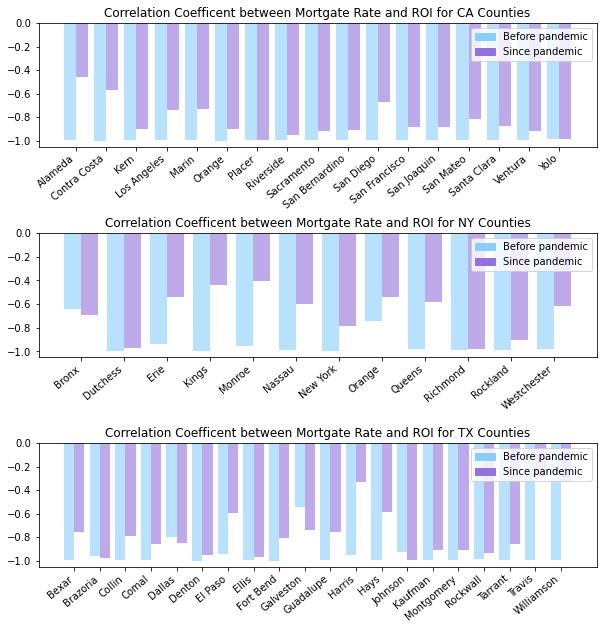

In [23]:
bar_width = 0.4
opacity = 0.6
x_label_fontsize = 10
bar_color1 = 'lightskyblue'
bar_color2 = 'mediumpurple'
legend_b4_pandemic = mpatches.Patch(color=bar_color1, label='Before pandemic')
legend_since_pandemic = mpatches.Patch(color=bar_color2, label='Since pandemic')

plt.figure()

# Bar plot for CA
plt.subplot(3,1,1)

x_labels = [x.replace(' County', '') for x in df_corr_ca_covid_stage.index.values]
x = np.arange(len(x_labels))
y1 = df_corr_ca_covid_stage['roi-rate_p'].values
y2 = df_corr_ca_covid_stage['roi-rate_s'].values

rects1 = plt.bar(x - bar_width/2, y1, bar_width,alpha=opacity, color=bar_color1)
rects2 = plt.bar(x + bar_width/2, y2, bar_width,alpha=opacity, color=bar_color2)

plt.xticks(ticks=x, labels=x_labels, rotation=40, fontsize=x_label_fontsize, ha='right')
#plt.gcf().set_size_inches(10,2)

plt.legend(handles=[legend_b4_pandemic, legend_since_pandemic], loc='upper right')
plt.title("Correlation Coefficent between Mortgate Rate and ROI for CA Counties", fontsize='12')



# Bar plot for NY
plt.subplot(3,1,2)

x_labels = [x.replace(' County', '') for x in df_corr_ny_covid_stage.index.values]
x = np.arange(len(x_labels))
y1 = df_corr_ny_covid_stage['roi-rate_p'].values
y2 = df_corr_ny_covid_stage['roi-rate_s'].values

rects1 = plt.bar(x - bar_width/2, y1, bar_width, alpha=opacity, color=bar_color1)
rects2 = plt.bar(x + bar_width/2, y2, bar_width, alpha=opacity, color=bar_color2)

plt.xticks(ticks=x, labels=x_labels, rotation=40, fontsize=x_label_fontsize, ha='right')
#plt.gcf().set_size_inches(10,2)

plt.legend(handles=[legend_b4_pandemic, legend_since_pandemic], loc='upper right')
plt.title("Correlation Coefficent between Mortgate Rate and ROI for NY Counties", y=1, fontsize='12')


# Bar plot for TX
plt.subplot(3,1,3)

x_labels = [x.replace(' County', '') for x in df_corr_tx_covid_stage.index.values]
x = np.arange(len(x_labels))
y1 = df_corr_tx_covid_stage['roi-rate_p'].values
y2 = df_corr_tx_covid_stage['roi-rate_s'].values

rects1 = plt.bar(x - bar_width/2, y1, bar_width, alpha=opacity, color=bar_color1)
rects2 = plt.bar(x + bar_width/2, y2, bar_width, alpha=opacity, color=bar_color2)

plt.xticks(ticks=x, labels=x_labels, rotation=40, fontsize=x_label_fontsize, ha='right')

plt.subplots_adjust(hspace=0.7)
plt.gcf().set_size_inches(10,10)

plt.legend(handles=[legend_b4_pandemic, legend_since_pandemic], loc='upper right')
plt.title("Correlation Coefficent between Mortgate Rate and ROI for TX Counties", y=1, fontsize='12')

plt.show()

### Statistically Signifiant Test for difference between Before and Since Pandemic correlation 

In [24]:
def add_corr_change_test(df_corr, sample_size):

    df_corr['selling_price-rent_change'] = df_corr[['selling_price-rent_p', 'selling_price-rent_s']].apply(lambda x: independent_corr(x['selling_price-rent_p'], x['selling_price-rent_s'], n=sample_size, method='fisher')[1] < 0.05, axis=1)
    df_corr['selling_price-roi_change'] = df_corr[['selling_price-roi_p', 'selling_price-roi_s']].apply(lambda x: independent_corr(x['selling_price-roi_p'], x['selling_price-roi_s'], n=sample_size, method='fisher')[1] < 0.05, axis=1)
    df_corr['selling_price-rate_change'] = df_corr[['selling_price-rate_p', 'selling_price-rate_s']].apply(lambda x: independent_corr(x['selling_price-rate_p'], x['selling_price-rate_s'], n=sample_size, method='fisher')[1] < 0.05, axis=1)

    df_corr['rent-roi_change'] = df_corr[['rent-roi_p', 'rent-roi_s']].apply(lambda x: independent_corr(x['rent-roi_p'], x['rent-roi_s'], n=sample_size, method='fisher')[1] < 0.05, axis=1)
    df_corr['rent-rate_change'] = df_corr[['rent-rate_p', 'rent-rate_s']].apply(lambda x: independent_corr(x['rent-rate_p'], x['rent-rate_s'], n=sample_size, method='fisher')[1] < 0.05, axis=1)

    df_corr['roi-rate_change'] = df_corr[['roi-rate_p', 'roi-rate_s']].apply(lambda x: independent_corr(x['roi-rate_p'], x['roi-rate_s'], n=sample_size, method='fisher')[1] < 0.05, axis=1)

    return df_corr 


In [25]:
no_of_records_per_county = df_ca.groupby(by='county')['date'].count()[0]
df_corr_ca_covid_stage = add_corr_change_test(df_corr_ca_covid_stage, no_of_records_per_county)
df_corr_tx_covid_stage = add_corr_change_test(df_corr_tx_covid_stage, no_of_records_per_county)
df_corr_ny_covid_stage = add_corr_change_test(df_corr_ny_covid_stage, no_of_records_per_county)

List hypothesis test results for each county. True means the two coefficients are significantly different.

In [26]:
df_corr_ca_covid_stage[['roi-rate_p', 'roi-rate_s', 'roi-rate_change']]

,roi-rate_p,roi-rate_s,roi-rate_change
Alameda County,-0.9963,-0.4555,True
Contra Costa County,-0.9977,-0.5677,True
Kern County,-0.9960,-0.9005,True
Los Angeles County,-0.9962,-0.7396,True
Marin County,-0.9887,-0.7287,True
Orange County,-0.9983,-0.8957,True
Placer County,-0.9964,-0.9890,True
Riverside County,-0.9934,-0.9460,True
Sacramento County,-0.9951,-0.9179,True
San Bernardino County,-0.9944,-0.9086,True


In [27]:
df_corr_ny_covid_stage[['roi-rate_p', 'roi-rate_s', 'roi-rate_change']]

,roi-rate_p,roi-rate_s,roi-rate_change
Bronx County,-0.6424,-0.6958,False
Dutchess County,-0.9939,-0.9748,True
Erie County,-0.9378,-0.5432,True
Kings County,-0.9941,-0.4417,True
Monroe County,-0.9540,-0.4062,True
Nassau County,-0.9892,-0.5963,True
New York County,-0.9948,-0.7865,True
Orange County,-0.7413,-0.5378,False
Queens County,-0.9800,-0.5792,True
Richmond County,-0.9922,-0.9808,True


In [28]:
df_corr_tx_covid_stage[['roi-rate_p', 'roi-rate_s', 'roi-rate_change']]

,roi-rate_p,roi-rate_s,roi-rate_change
Bexar County,-0.9919,-0.7523,True
Brazoria County,-0.9609,-0.9745,False
Collin County,-0.9946,-0.7884,True
Comal County,-0.9946,-0.8608,True
Dallas County,-0.8012,-0.8486,False
Denton County,-0.9973,-0.9525,True
El Paso County,-0.9417,-0.5955,True
Ellis County,-0.9935,-0.9639,True
Fort Bend County,-0.9994,-0.8053,True
Galveston County,-0.5459,-0.7403,False


Result shows the two coefficients are significantly different for 43 out of 49 (88%) counties. Overall, this concludes that the strength of relationship between Mortgage Rate and ROI did change since pandemic. 

### Output Data Files

In [29]:
df_corr_ca_covid_stage.to_csv('./output/corr_ca.csv')
df_corr_tx_covid_stage.to_csv('./output/corr_tx.csv')
df_corr_ny_covid_stage.to_csv('./output/corr_ny.csv')

<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=718fdf0e-933b-4ec5-90a8-5b2fe887b720' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>